<a href="https://colab.research.google.com/github/Aviral-Aggarwal/Retail_models/blob/master/Retail_NN_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# New Section

In [2]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
warnings.filterwarnings('ignore')

In [3]:
input_dir = '/content/gdrive/My Drive/m5-forecasting-accuracy/'

#CHECK AGAIN HOW THIS IS WORKING, IS IT ZIP MECHANISM OR SOMETHING ELSE
#Standard function, copied from stack exchange
def reduce_mem_usage(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
def load_df(file_path):
    t1 = time.time()
    df = pd.read_csv(file_path)
    df = reduce_mem_usage(df=df, verbose=True)
    print('The shape of data frame is ', df.shape)
    t2 = time.time()
    print('\nTime taken to load the DataFrame is:', (t2-t1))
    return df

In [5]:
train = load_df(input_dir + 'hobbies2_train.csv')
test = load_df(input_dir + 'hobbies2_test.csv')

Mem. usage decreased to 173.65 Mb (71.5% reduction)
The shape of data frame is  (2045946, 39)

Time taken to load the DataFrame is: 9.219415187835693
Mem. usage decreased to 26.15 Mb (31.4% reduction)
The shape of data frame is  (128140, 39)

Time taken to load the DataFrame is: 0.780364990234375


In [6]:
train.drop(train.columns[0], axis=1, inplace=True)
test.drop(test.columns[0], axis=1, inplace=True)

In [7]:
valid = test[test["month"]<3]
test = test[test["month"]>=3]

In [8]:
y_train = train['Quantity_sold']
X_train = train.drop('Quantity_sold', axis=1)
y_test = test['Quantity_sold']
X_test = test.drop('Quantity_sold', axis=1)
y_val = valid['Quantity_sold']
X_val = valid.drop('Quantity_sold', axis=1)

In [9]:
del train
del valid

I am doing the scaling before the label encoding and replacing NaN values, since I don't want those variables to be scaled 

In [10]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [11]:
cat_cols= ['item_id', 'store_id']
num_cols= list( set(list(X_train.columns))-set(cat_cols) )

In [12]:
len(num_cols)

35

In [13]:
#X_train[num_cols] = X_train[num_cols].fillna(X_train[num_cols].mean())
#X_test[num_cols] = X_test[num_cols].fillna(X_test[num_cols].mean())

In [14]:
X_train.fillna(1000, inplace=True)
X_test.fillna(1000, inplace=True)
X_val.fillna(1000, inplace=True)

In [15]:
#X_train_scaled = min_max_scaler.fit_transform(X_train[num_cols])
#X_test_scaled = min_max_scaler.fit_transform(X_test[num_cols])

In [16]:
#X_train_scaled.shape

In [17]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
def label_encoding(X):
  d = defaultdict(LabelEncoder)
  categorical_mask = (X.dtypes == object)
  categorical_columns = X.columns[categorical_mask].tolist()
 
  print(X[categorical_columns].head())

  le = LabelEncoder()
  for cat in categorical_columns:
      le.fit(X[cat])
      #print(le.classes_)
      X[cat]=le.transform(X[cat])

  print(X[categorical_columns].head())
  return X

In [18]:
X_train = label_encoding(X_train)
X_test = label_encoding(X_test)
X_val = label_encoding(X_val)

         item_id store_id
0  HOBBIES_2_001     CA_1
1  HOBBIES_2_001     CA_1
2  HOBBIES_2_001     CA_1
3  HOBBIES_2_001     CA_1
4  HOBBIES_2_001     CA_1
   item_id  store_id
0        0         0
1        0         0
2        0         0
3        0         0
4        0         0
          item_id store_id
31  HOBBIES_2_001     CA_1
32  HOBBIES_2_001     CA_1
33  HOBBIES_2_001     CA_1
34  HOBBIES_2_001     CA_1
35  HOBBIES_2_001     CA_1
    item_id  store_id
31        0         0
32        0         0
33        0         0
34        0         0
35        0         0
         item_id store_id
0  HOBBIES_2_001     CA_1
1  HOBBIES_2_001     CA_1
2  HOBBIES_2_001     CA_1
3  HOBBIES_2_001     CA_1
4  HOBBIES_2_001     CA_1
   item_id  store_id
0        0         0
1        0         0
2        0         0
3        0         0
4        0         0


I am especially changing the values of the year column to have better scaling operation, since they will be treated as proper continuous numerical variables

In [19]:
X_train['year'] -= 2010
X_test['year'] -= 2010
X_val['year'] -= 2010

In [20]:
X_train[num_cols] = X_train[num_cols]/X_train[num_cols].max()
X_test[num_cols] = X_test[num_cols]/X_test[num_cols].max()
X_val[num_cols] = X_val[num_cols]/X_val[num_cols].max()

In [21]:
X_train = X_train[X_train.columns[0:9]]
X_val = X_val[X_val.columns[0:9]]
X_test = X_test[X_test.columns[0:9]]

In [22]:
X_train

,item_id,store_id,sell_price,wday,month,year,mrp,discount,week_number
0,0,0,0.548828,0.142857,0.083333,0.166667,0.548828,0.000000,0.075472
1,0,0,0.548828,0.285714,0.083333,0.166667,0.548828,0.000000,0.075472
2,0,0,0.548828,0.428571,0.083333,0.166667,0.548828,0.000000,0.094340
3,0,0,0.548828,0.571429,0.166667,0.166667,0.548828,0.000000,0.094340
4,0,0,0.548828,0.714286,0.166667,0.166667,0.548828,0.000000,0.094340
...,...,...,...,...,...,...,...,...,...
2045941,148,9,0.097351,0.428571,0.083333,1.000000,0.247803,0.208862,0.075472
2045942,148,9,0.097351,0.571429,0.083333,1.000000,0.247803,0.208862,0.075472
2045943,148,9,0.097351,0.714286,0.083333,1.000000,0.247803,0.208862,0.075472
2045944,148,9,0.097351,0.857143,0.083333,1.000000,0.247803,0.208862,0.075472


In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [24]:
model = Sequential()
model.add(Dense(128, input_dim=9, activation= "relu"))
#model.add(Dense(256, activation="tanh"))
#model.add(Dense(128, activation= "tanh"))
#model.add(Dense(128, activation= "tanh"))
#model.add(Dense(64, activation= "relu"))
model.add(Dense(64, activation= "tanh"))
model.add(Dense(32, activation= "relu"))
model.add(Dense(32, activation="tanh"))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9

In [25]:
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error", "accuracy"])

In [26]:
model.fit(X_train, y_train, epochs=3, batch_size = 512, validation_data=(X_val, y_val))

Epoch 1/3
3996/3996 [==============================] - 13s 3ms/step - loss: 0.7331 - mean_squared_error: 0.7331 - accuracy: 0.8492 - val_loss: 0.6297 - val_mean_squared_error: 0.6297 - val_accuracy: 0.8353
Epoch 2/3
3996/3996 [==============================] - 14s 4ms/step - loss: 0.7312 - mean_squared_error: 0.7312 - accuracy: 0.8482 - val_loss: 0.6272 - val_mean_squared_error: 0.6272 - val_accuracy: 0.8355
Epoch 3/3
3996/3996 [==============================] - 14s 3ms/step - loss: 0.7283 - mean_squared_error: 0.7283 - accuracy: 0.8425 - val_loss: 0.6297 - val_mean_squared_error: 0.6297 - val_accuracy: 0.7902


In [28]:
#model.save(input_dir + 'model_try1')

In [29]:
model = keras.models.load_model(input_dir + 'model_try2')

In [27]:
y_pred = model.predict(X_test)
y_pred.reshape(y_pred.shape[0])
predictions = np.round(np.array(y_pred))

In [28]:
print(y_pred[0:100])
print(y_test)

[[0.09109205]
 [0.09205043]
 [0.09294938]
 [0.09377985]
 [0.08906967]
 [0.08983376]
 [0.09044585]
 [0.09107811]
 [0.09203777]
 [0.09291388]
 [0.09377443]
 [0.0889396 ]
 [0.08990918]
 [0.09052971]
 [0.09107365]
 [0.09202645]
 [0.09290929]
 [0.09376442]
 [0.08879361]
 [0.08975308]
 [0.09045219]
 [0.0911241 ]
 [0.09202199]
 [0.09289501]
 [0.09374765]
 [0.08864604]
 [0.08961532]
 [0.09030591]
 [0.09112547]
 [0.09200972]
 [0.09287797]
 [0.09464788]
 [0.0887694 ]
 [0.08967964]
 [0.09044257]
 [0.09140707]
 [0.09225141]
 [0.09326129]
 [0.09441609]
 [0.08858861]
 [0.08949722]
 [0.09029944]
 [0.09124646]
 [0.09207808]
 [0.09300277]
 [0.09416356]
 [0.08841436]
 [0.08934002]
 [0.09015593]
 [0.09107976]
 [0.09191804]
 [0.09275461]
 [0.09392101]
 [0.08826327]
 [0.08920798]
 [0.08774028]
 [0.08813169]
 [0.08848254]
 [0.08866554]
 [0.08609199]
 [0.08665897]
 [0.08729962]
 [0.08772171]
 [0.08812504]
 [0.08851045]
 [0.08870624]
 [0.08595226]
 [0.08669412]
 [0.08731136]
 [0.08770335]
 [0.08811869]
 [0.08

In [29]:
y_test = y_test.values.reshape(y_pred.shape)

In [30]:
print(model.history.history.keys())

dict_keys([])


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

KeyError: ignored

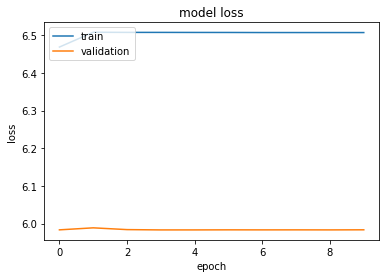

In [ ]:
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

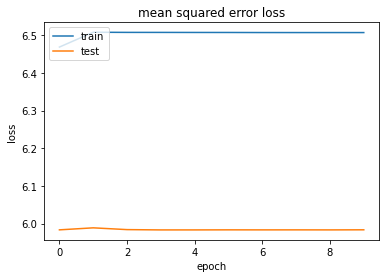

In [ ]:
# summarize history for loss
plt.plot(model.history.history['mean_squared_error'])
plt.plot(model.history.history['val_mean_squared_error'])
plt.title('mean squared error loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
print(y_pred.shape)
print(predictions.shape)
print(y_test.shape)

(81950, 1)
(81950, 1)
(81950, 1)


In [34]:
from sklearn.metrics import accuracy_score, mean_squared_error

score = np.sqrt(mean_squared_error(y_test, y_pred))
print (score)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

0.77813846
Accuracy: 79.71%


In [35]:
def eval_results(yhat_mean, y):
    temp_dict = {}
    temp_dict['MAD'] = np.nanmean(np.abs(y - yhat_mean))
    #temp_dict['MAPE'] = np.nanmean(np.abs((y-yhat_mean)/(y+1e-7)))
    temp_dict['MSE'] = np.nanmean(np.square(y - yhat_mean))
    temp_dict['WMAPE'] = np.nansum(np.abs(y - yhat_mean)) / np.nansum(y)
    temp_dict['MD'] = np.nanmean(y - yhat_mean)
    temp_dict['mean'] = np.nanmean(y)
    temp_dict['SMAPE'] = 100. * np.nanmean(np.abs(y - yhat_mean) / ((np.abs(y) + np.abs(yhat_mean)) / 2.))
    # print(temp_dict)
    return temp_dict

In [36]:
print(eval_results(predictions, y_test))

{'MAD': 0.28435633, 'MSE': 0.6733496, 'WMAPE': 1.1396781923998631, 'MD': 0.1880537, 'mean': 0.24950579621720562, 'SMAPE': 189.7203803062439}


In [37]:
def zeros_sep(y_test, predictions):
  zeros_real = y_test[y_test==0]
  other_real = y_test[y_test!=0]
  zeros_pred = []
  other_pred = []
  i=0
  for y in y_test:
    if y==0:
      zeros_pred.append(predictions[i, 0])
    else:
      other_pred.append(predictions[i, 0])
    i=i+1

  print(len(other_real), len(other_pred))

  count =0
  for i in other_pred:
    if i<0.05:
      count+=1
  print("Count of zeros which are supposed to be non zero:  ", count)

  mad_zeros = np.nanmean(np.abs(zeros_pred - zeros_real))
  mape_other = np.nanmean(np.abs((other_pred-other_real)/other_real))

  print("MAD_zeros:   ", mad_zeros)
  print("MAPE_other:  ", mape_other)

In [38]:
zeros_sep(y_test, predictions)

13358 13358
Count of zeros which are supposed to be non zero:   12268
MAD_zeros:    0.057528574
MAPE_other:   0.93809456


In [39]:
predictions

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [40]:
X_test.shape

(81950, 9)

In [41]:
#weekly = pd.concat([X_test, y_test, predictions], axis='col')

In [42]:
test = test[test.columns[0:10]]

In [43]:
test.rename(columns={'Quantity_sold': 'y_test'}, inplace=True)

In [44]:
test.drop(['sell_price', 'month', 'year', 'mrp', 'discount'], axis=1, inplace=True)

In [45]:
test.drop('wday', axis=1, inplace=True)

In [46]:
#weekly = pd.merge(left = test, right = predictions, how='inner', left_on = True)

In [47]:
test['rounded'] = predictions
test['pred'] = y_pred

In [48]:
test

,item_id,store_id,y_test,week_number,rounded,pred
31,HOBBIES_2_001,CA_1,0,9,0.0,0.091092
32,HOBBIES_2_001,CA_1,0,9,0.0,0.092050
33,HOBBIES_2_001,CA_1,0,9,0.0,0.092949
34,HOBBIES_2_001,CA_1,0,9,0.0,0.093780
35,HOBBIES_2_001,CA_1,0,9,0.0,0.089070
...,...,...,...,...,...,...
128135,HOBBIES_2_149,WI_3,2,16,0.0,0.420280
128136,HOBBIES_2_149,WI_3,0,16,0.0,0.399436
128137,HOBBIES_2_149,WI_3,0,16,0.0,0.376525
128138,HOBBIES_2_149,WI_3,0,16,0.0,0.478217


In [49]:
weekly = test.groupby(by = ['item_id', 'store_id', 'week_number']).sum()

In [50]:
weekly

y_test  rounded      pred
item_id       store_id week_number                           
HOBBIES_2_001 CA_1     9                 0      0.0  0.548775
                       10                1      0.0  0.639099
                       11                1      0.0  0.638850
                       12                0      0.0  0.638502
                       13                2      0.0  0.639416
...                                    ...      ...       ...
HOBBIES_2_149 WI_3     12                1      0.0  2.389758
                       13                1      0.0  2.612718
                       14                0      0.0  2.907435
                       15                1      0.0  2.972493
                       16                2      0.0  3.034261

[11920 rows x 3 columns]

In [52]:
weekly_rounded = weekly['rounded']
weekly_y = weekly['y_test']
weekly_pred = weekly['pred']

In [53]:
print(eval_results(weekly_pred, weekly_y))

{'MAD': 1.7833314, 'MSE': 7.2985587, 'WMAPE': 1.0396298012850296, 'MD': -0.1753953, 'mean': 1.7153523489932887, 'SMAPE': 116.11933771212696}


In [54]:
weekly_pred.to_numpy()
l = len(weekly_pred)

In [55]:
print(l)

11920


In [58]:
score = np.sqrt(mean_squared_error(weekly_y, weekly_pred))
print (score)
accuracy = accuracy_score(weekly_y, weekly_rounded)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

2.7015846
Accuracy: 38.54%


In [59]:
def zeros_week(y_test, predictions):
  zeros_real = y_test[y_test==0]
  other_real = y_test[y_test!=0]
  zeros_pred = []
  other_pred = []
  i=0
  for y in y_test:
    if y==0:
      zeros_pred.append(predictions[i])
    else:
      other_pred.append(predictions[i])
    i=i+1

  print(len(other_real), len(other_pred))

  count =0
  for i in other_pred:
    if i<0.05:
      count+=1
  print("Count of zeros which are supposed to be non zero:  ", count)

  mad_zeros = np.nanmean(np.abs(zeros_pred - zeros_real))
  mape_other = np.nanmean(np.abs((other_pred-other_real)/other_real))

  print("MAD_zeros:   ", mad_zeros)
  print("MAPE_other:  ", mape_other)

In [60]:
zeros_week(weekly_y.to_numpy(), weekly_pred.to_numpy())

7033 7033
Count of zeros which are supposed to be non zero:   0
MAD_zeros:    1.8153328
MAPE_other:   0.6034423


In [61]:
weekly.nlargest(5, columns='y_test', keep='first')

,,,y_test,rounded,pred
item_id,store_id,week_number,,,
HOBBIES_2_059,TX_2,14,41,7.0,5.882174
HOBBIES_2_124,TX_3,14,34,7.0,4.458643
HOBBIES_2_042,CA_3,14,32,6.0,4.133763
HOBBIES_2_129,WI_2,16,32,7.0,4.622562
HOBBIES_2_075,CA_3,11,31,0.0,1.660194


In [62]:
weekly.nlargest(5, columns='pred', keep='first')

y_test  rounded      pred
item_id       store_id week_number                           
HOBBIES_2_007 TX_3     16                0      7.0  9.642077
                       15                1      7.0  9.448105
                       14                1      7.0  9.207363
              TX_2     16                1      7.0  9.015339
                       15                1      7.0  8.763023

In [63]:
weekly.nsmallest(5, columns='y_test', keep='first')

y_test  rounded      pred
item_id       store_id week_number                           
HOBBIES_2_001 CA_1     9                 0      0.0  0.548775
                       12                0      0.0  0.638502
              CA_2     9                 0      0.0  0.525771
                       10                0      0.0  0.613009
                       11                0      0.0  0.612755

In [64]:
weekly.nsmallest(5, columns='pred', keep='first')

y_test  rounded      pred
item_id       store_id week_number                           
HOBBIES_2_001 CA_4     9                 0      0.0  0.508497
              CA_3     9                 1      0.0  0.509461
              CA_2     9                 0      0.0  0.525771
              CA_1     9                 0      0.0  0.548775
              TX_1     9                 0      0.0  0.564402

In [65]:
total_prod = weekly.groupby(by=['item_id', 'store_id']).sum()

In [66]:
total_prod

y_test  rounded       pred
item_id       store_id                            
HOBBIES_2_001 CA_1         9.0      0.0   5.020352
              CA_2         1.0      0.0   4.799180
              CA_3         4.0      0.0   4.643863
              CA_4         2.0      0.0   4.608061
              TX_1         2.0      0.0   4.982809
...                        ...      ...        ...
HOBBIES_2_149 TX_2        36.0      1.0  23.360622
              TX_3        22.0      0.0  22.678087
              WI_1        13.0      0.0  21.951481
              WI_2        15.0      0.0  21.170826
              WI_3        15.0      0.0  20.318922

[1490 rows x 3 columns]

In [67]:
total_prod.nlargest(5, columns='y_test', keep='first')

y_test  rounded       pred
item_id       store_id                            
HOBBIES_2_075 CA_3       171.0      0.0  13.055459
HOBBIES_2_043 CA_3       126.0      1.0  18.049553
              TX_2       118.0      0.0  17.086561
              TX_3       116.0      0.0  17.105015
              CA_1       114.0      4.0  18.636974

In [69]:
total_prod.nlargest(5, columns='pred', keep='first')

y_test  rounded       pred
item_id       store_id                            
HOBBIES_2_007 TX_3        17.0     55.0  58.559299
              TX_2        19.0     55.0  50.816540
HOBBIES_2_059 CA_1        54.0     55.0  48.006489
              CA_2        46.0     55.0  47.564163
HOBBIES_2_007 CA_1        20.0     46.0  46.416355